In [14]:
import mysql.connector
from mysql.connector import Error
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from wordcloud import WordCloud

In [103]:
def connect_to_mysql(host, user, password, database):
    try:
        connection = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database)
        if connection.is_connected():
            print("Connected to MySQL database")
            return connection
    except Error as e:
        print(f"Error: {e}")
        return None

def fetch_data_from_mysql(connection, query):
    try:
        cursor = connection.cursor()
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        result = cursor.fetchall()

        df = pd.DataFrame(result, columns=columns)
        return df
    except Error as e:
        print(f"Error: {e}")
        return None

In [104]:
# Sử dụng các hàm đã định nghĩa
connection = connect_to_mysql('localhost', 'root', 'Nokhai14442002', 'movies_data')

Connected to MySQL database


In [105]:
query = "SELECT * FROM movies"
movies_df = fetch_data_from_mysql(connection, query)
display(movies_df.head())
display(movies_df.info())

,genre_ids,id,original_language,overview,popularity,release_date,title,vote_average,vote_count
0,"[35, 18, 10749, 80]",2,fi,After the coal mine he works at closes and his...,10.381,1988-10-21,Ariel,7.100,335
1,[35],5,en,It's Ted the Bellhop's first night on the job....,15.415,1995-12-09,Four Rooms,5.847,2627
2,"[12, 28, 878]",11,en,Princess Leia is captured and held hostage by ...,88.989,1977-05-25,Star Wars,8.204,20554
3,"[16, 10751]",12,en,"Nemo, an adventurous young clownfish, is unexp...",92.462,2003-05-30,Finding Nemo,7.800,19192
4,"[35, 18, 10749]",13,en,A man with a low IQ has accomplished great thi...,90.504,1994-06-23,Forrest Gump,8.500,27415


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9676 entries, 0 to 9675
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          9676 non-null   object        
 1   id                 9676 non-null   int64         
 2   original_language  9676 non-null   object        
 3   overview           9676 non-null   object        
 4   popularity         9676 non-null   float64       
 5   release_date       9642 non-null   datetime64[ns]
 6   title              9676 non-null   object        
 7   vote_average       9676 non-null   float64       
 8   vote_count         9676 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 680.5+ KB


None

In [106]:
movies_df['release_date'].fillna(pd.to_datetime('1900-01-01'), inplace=True)

C:\Users\trong\AppData\Local\Temp\ipykernel_7048\2470552955.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_df['release_date'].fillna(pd.to_datetime('1900-01-01'), inplace=True)


In [107]:
print(movies_df['title'].duplicated().sum()) 
movies_df = movies_df.loc[~movies_df['title'].duplicated()]

333


In [108]:
query = "SELECT * FROM genres"
genres_df = fetch_data_from_mysql(connection, query)
display(genres_df.head())
display(genres_df.info())

,id,name
0,12,Adventure
1,14,Fantasy
2,16,Animation
3,18,Drama
4,27,Horror


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19 non-null     int64 
 1   name    19 non-null     object
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes


None

In [109]:
genre_mapping = dict(zip(genres_df['id'], genres_df['name']))
def map_genre_ids(genre_ids):
    if not genre_ids or genre_ids == '[]':  # Kiểm tra giá trị rỗng hoặc danh sách trống
        return ['Unknown']
    try:
        genre_ids = [int(g.strip()) for g in genre_ids.strip('[]').split(',') if g.strip()]
        genre_names = [genre_mapping.get(genre_id, 'Unknown') for genre_id in genre_ids]
        return genre_names
    except ValueError:
        return ['Unknown']

movies_df['genre_names'] = movies_df['genre_ids'].apply(map_genre_ids)
movies_df.drop(columns=['genre_ids'], inplace=True)
display(movies_df.head())

,id,original_language,overview,popularity,release_date,title,vote_average,vote_count,genre_names
0,2,fi,After the coal mine he works at closes and his...,10.381,1988-10-21,Ariel,7.100,335,"[Comedy, Drama, Romance, Crime]"
1,5,en,It's Ted the Bellhop's first night on the job....,15.415,1995-12-09,Four Rooms,5.847,2627,[Comedy]
2,11,en,Princess Leia is captured and held hostage by ...,88.989,1977-05-25,Star Wars,8.204,20554,"[Adventure, Action, Science Fiction]"
3,12,en,"Nemo, an adventurous young clownfish, is unexp...",92.462,2003-05-30,Finding Nemo,7.800,19192,"[Animation, Family]"
4,13,en,A man with a low IQ has accomplished great thi...,90.504,1994-06-23,Forrest Gump,8.500,27415,"[Comedy, Drama, Romance]"


In [110]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9343 entries, 0 to 9675
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 9343 non-null   int64         
 1   original_language  9343 non-null   object        
 2   overview           9343 non-null   object        
 3   popularity         9343 non-null   float64       
 4   release_date       9343 non-null   datetime64[ns]
 5   title              9343 non-null   object        
 6   vote_average       9343 non-null   float64       
 7   vote_count         9343 non-null   int64         
 8   genre_names        9343 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 729.9+ KB


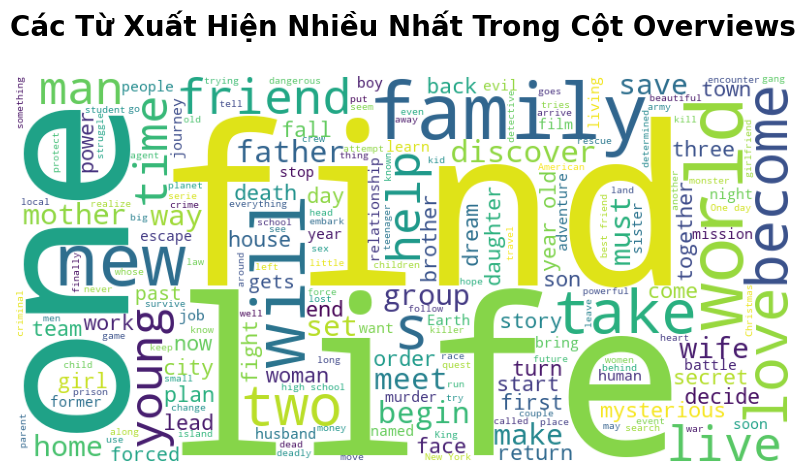

In [111]:
wc = WordCloud(background_color='white', width=800, height=400).generate(' '.join(movies_df['overview']))
plt.figure(figsize = (10, 6))
plt.title('Các Từ Xuất Hiện Nhiều Nhất Trong Cột Overviews\n', fontsize=20, weight=600)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [112]:
movies_df.head()

,id,original_language,overview,popularity,release_date,title,vote_average,vote_count,genre_names
0,2,fi,After the coal mine he works at closes and his...,10.381,1988-10-21,Ariel,7.100,335,"[Comedy, Drama, Romance, Crime]"
1,5,en,It's Ted the Bellhop's first night on the job....,15.415,1995-12-09,Four Rooms,5.847,2627,[Comedy]
2,11,en,Princess Leia is captured and held hostage by ...,88.989,1977-05-25,Star Wars,8.204,20554,"[Adventure, Action, Science Fiction]"
3,12,en,"Nemo, an adventurous young clownfish, is unexp...",92.462,2003-05-30,Finding Nemo,7.800,19192,"[Animation, Family]"
4,13,en,A man with a low IQ has accomplished great thi...,90.504,1994-06-23,Forrest Gump,8.500,27415,"[Comedy, Drama, Romance]"


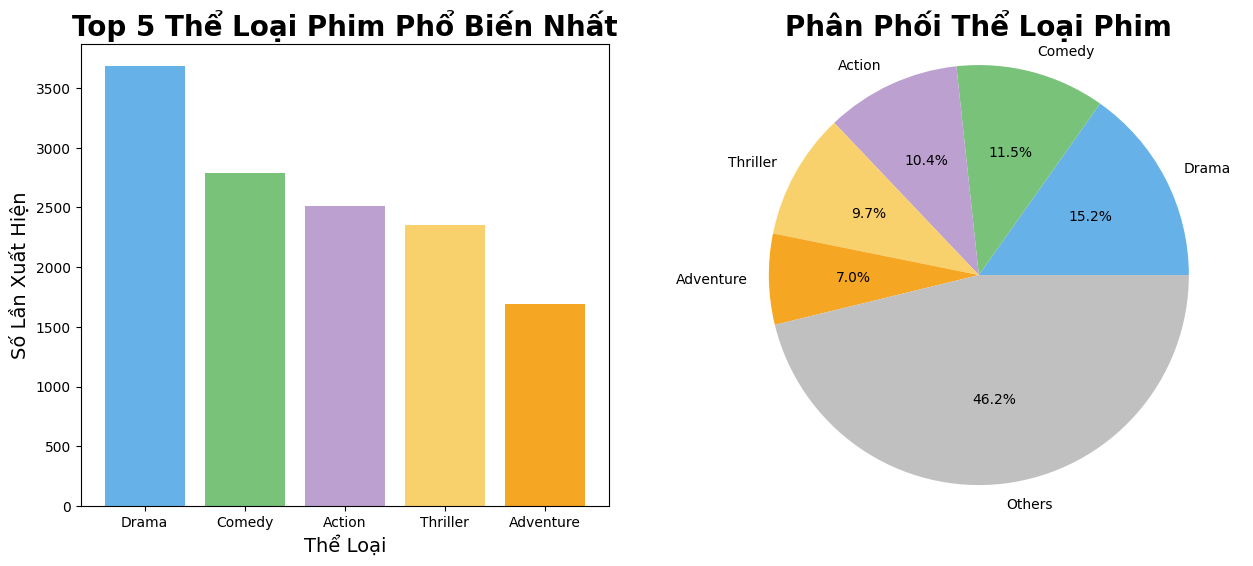

In [113]:
#Top 5 the loai phim
all_genres = []
for genres in movies_df['genre_names']:
    all_genres.extend(genres)

genre_counts = pd.Series(all_genres).value_counts()
genre_counts_df = pd.DataFrame({'Genre': genre_counts.index, 'Count': genre_counts.values})
genre_counts_df.head()
top_5_genres = genre_counts_df.head(5)
# Tính số lượng thể loại "Khác"
remaining_count = genre_counts.sum() - top_5_genres['Count'].sum()
# Tạo DataFrame cho "Khác" và thêm vào top 5
other_genres = pd.DataFrame({'Genre': ['Others'], 'Count': [remaining_count]})
final_genres = pd.concat([top_5_genres, other_genres], ignore_index=True)

colors =  ['#66B2E8', '#78C279', '#BBA0D0', '#F9D16C', '#F5A623', '#C0C0C0']
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Vẽ biểu đồ cột

ax[0].bar(top_5_genres['Genre'], top_5_genres['Count'], color=colors[:-1])
ax[0].set_title('Top 5 Thể Loại Phim Phổ Biến Nhất', fontsize = 20, fontweight = 600)
ax[0].set_xlabel('Thể Loại', fontsize=14)
ax[0].set_ylabel('Số Lần Xuất Hiện', fontsize=14)


# Vẽ biểu đồ hình tròn
ax[1].pie(final_genres['Count'], labels=final_genres['Genre'], colors=colors, autopct='%1.1f%%')
ax[1].set_title('Phân Phối Thể Loại Phim', fontsize=20, fontweight=600)
ax[1].axis('equal')


plt.show()

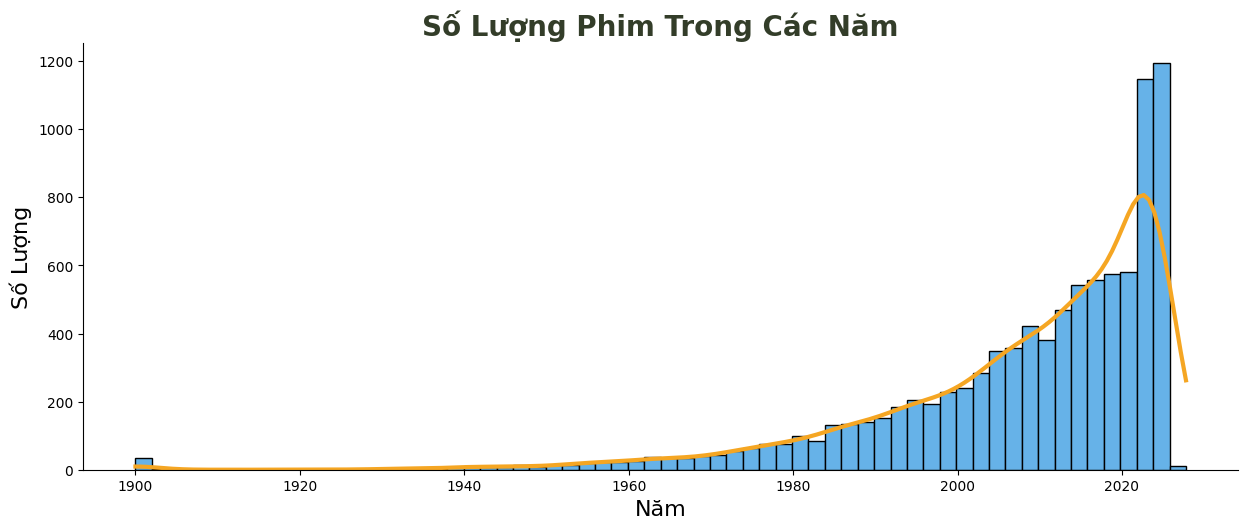

In [114]:
sns.displot(data=movies_df, x='release_date', kind='hist', kde=True,
            color='#F5A623', facecolor='#66B2E8', line_kws={'lw': 3}, aspect=2.5)
plt.xlabel('Năm', fontsize = 16)
plt.ylabel('Số Lượng', fontsize = 16)
plt.title('Số Lượng Phim Trong Các Năm', fontsize=20, weight=600, color='#333d29')
plt.show()

In [115]:
def count_items(column):
    all_items = []
    for i in column:
        all_items.extend(i)
    item_counts = pd.Series(all_items).value_counts()
    return pd.DataFrame({'Item': item_counts.index, 'Count': item_counts.values})

original_counts_df = count_items(movies_df['original_language'])
#cast_counts_df = count_items(movies_df['cast'])
#crew_counts_df = count_items(movies_df['crew'])

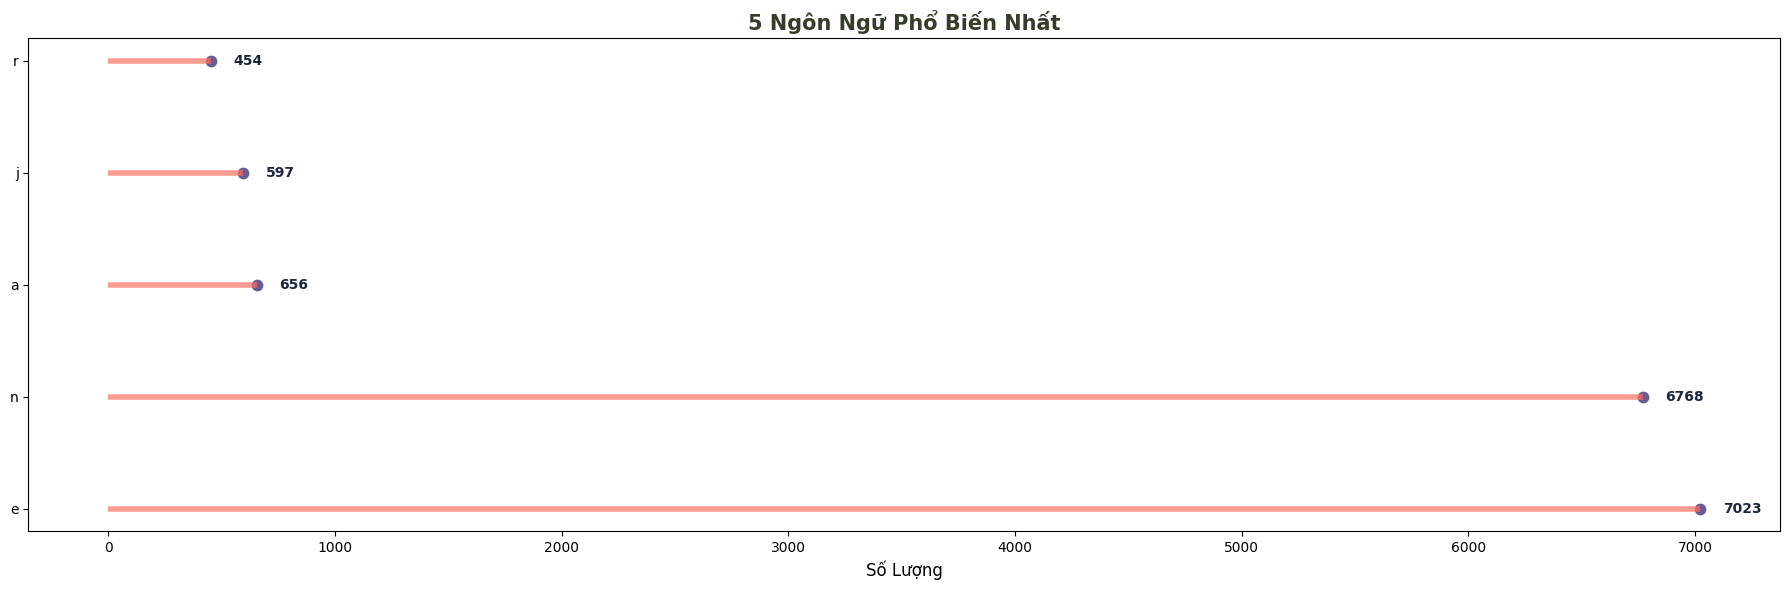

In [116]:
top_original = original_counts_df.nlargest(5, 'Count')

# Thiết lập hình và các trục
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

# Biểu đồ cho top_original
ax.hlines(y=top_original['Item'], xmin=0, xmax=top_original['Count'], color='#FF6F61', alpha=0.7, linewidth=4)
ax.scatter(x=top_original['Count'], y=top_original['Item'], s=100, color='#6B5B95', edgecolor='white', linewidth=1.5)
ax.set_title('5 Ngôn Ngữ Phổ Biến Nhất', fontsize=15, weight='bold', color='#333d29')

# Thêm giá trị vào các điểm trên biểu đồ
for i, value in enumerate(top_original['Count']):
    ax.text(value + 100, i, value, va='center', fontsize=10, weight='bold', color='#1C2541')

ax.set_xlabel('Số Lượng', fontsize=12)

# Hiển thị các biểu đồ
plt.tight_layout()
plt.show()

C:\Users\trong\AppData\Local\Temp\ipykernel_7048\2538414733.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=movies_df,


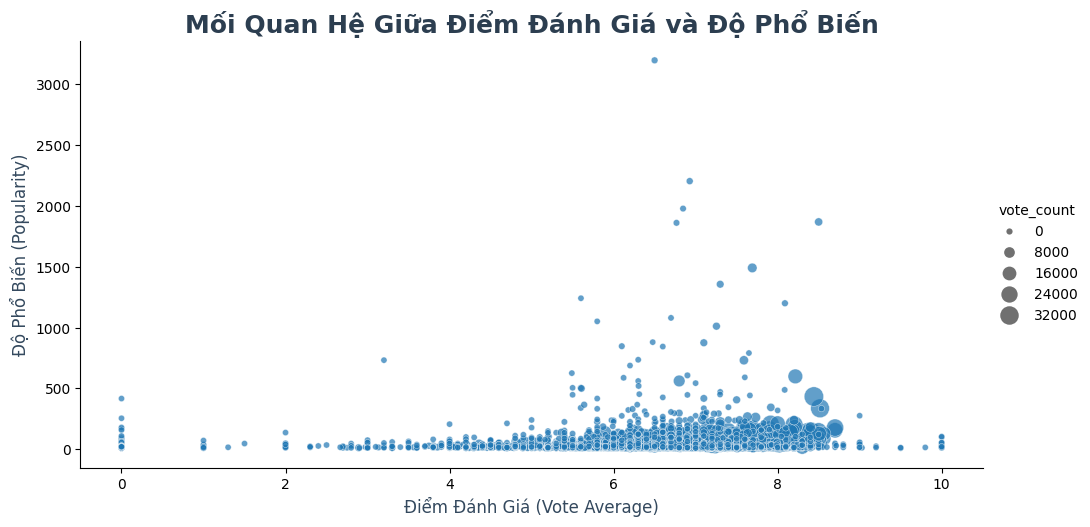

In [117]:
sns.relplot(data=movies_df,
                      x='vote_average',
                      y='popularity',
                      size='vote_count',
                      sizes=(20, 200),
                      alpha=.7,
                      aspect=2,
                      palette='viridis')  # Tắt legend nếu không cần thiết

plt.title('Mối Quan Hệ Giữa Điểm Đánh Giá và Độ Phổ Biến', fontsize=18, weight='bold', color='#2c3e50')
plt.xlabel('Điểm Đánh Giá (Vote Average)', fontsize=12, color='#34495e')
plt.ylabel('Độ Phổ Biến (Popularity)', fontsize=12, color='#34495e')
plt.show()

In [118]:
movies_df.info()
movies_df['release_date'].fillna(pd.to_datetime('1900-01-01'), inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 9343 entries, 0 to 9675
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 9343 non-null   int64         
 1   original_language  9343 non-null   object        
 2   overview           9343 non-null   object        
 3   popularity         9343 non-null   float64       
 4   release_date       9343 non-null   datetime64[ns]
 5   title              9343 non-null   object        
 6   vote_average       9343 non-null   float64       
 7   vote_count         9343 non-null   int64         
 8   genre_names        9343 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 729.9+ KB


C:\Users\trong\AppData\Local\Temp\ipykernel_7048\3759190708.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_df['release_date'].fillna(pd.to_datetime('1900-01-01'), inplace=True)


<Axes: title={'center': 'Correlation of Movie Features\n'}>

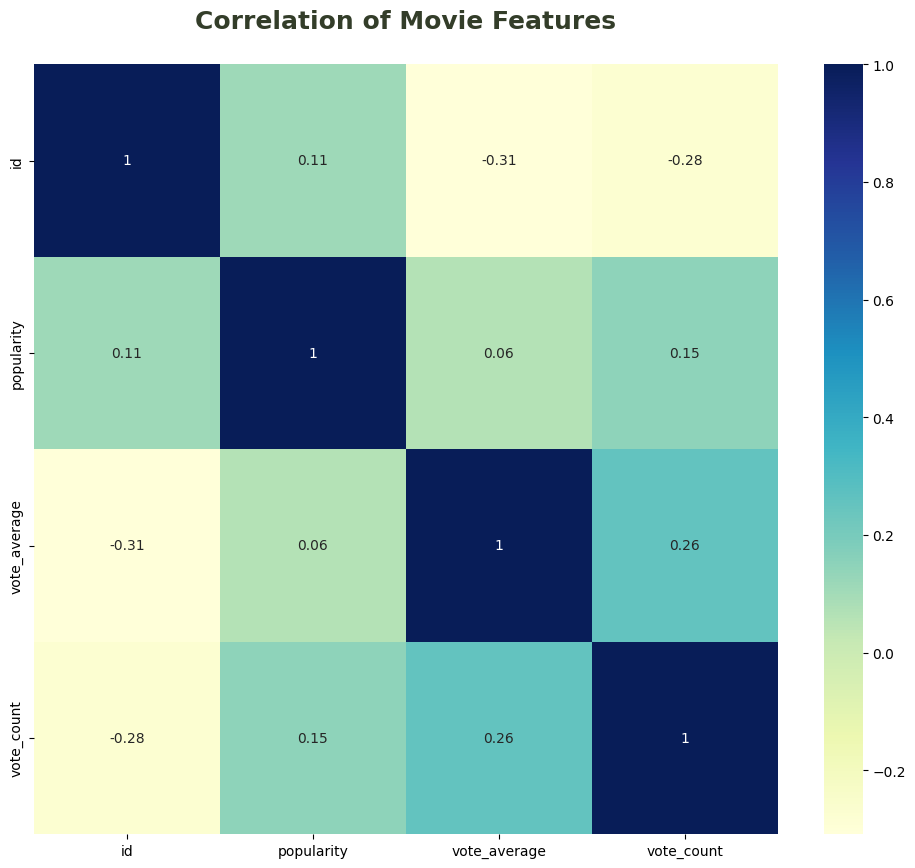

In [119]:
movies_numerical_df = movies_df.select_dtypes(exclude=['object', 'datetime64[ns]'])

plt.figure(figsize=(12, 10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(movies_numerical_df.corr(), annot=True, cmap = 'YlGnBu')

## Transforms

In [120]:
R = movies_df['vote_average']
v = movies_df['vote_count']
m = movies_df['vote_count'].quantile(0.8)
C = movies_df['vote_average'].mean()

movies_df['weighted_average'] = (R*v + C*m)/(v+m)

In [121]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(movies_df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = movies_df['title']
weighted_df.head()

,popularity,weighted_average
title,,
Ariel,0.000587,0.445652
Four Rooms,0.002166,0.354717
Star Wars,0.025239,0.868120
Finding Nemo,0.026328,0.769857
Forrest Gump,0.025714,0.951841


In [122]:
print(weighted_df.index.duplicated().sum()) 

0


In [123]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [124]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
title,,,
Venom: The Last Dance,1.000000,0.431767,0.772707
The Wild Robot,0.583406,0.739580,0.645875
Terrifier 3,0.688585,0.468808,0.600674
Deadpool & Wolverine,0.464895,0.674730,0.548829
Gladiator II,0.617763,0.440259,0.546761
Apocalypse Z: The Beginning of the End,0.581052,0.440261,0.524735
The Substance,0.422746,0.541573,0.470277
Interstellar,0.133280,0.947264,0.458874
Gladiator,0.185279,0.866192,0.457644


In [125]:
used_df = movies_df[['title', 'genre_names', 'overview']]

In [126]:
used_df.head()

,title,genre_names,overview
0,Ariel,"[Comedy, Drama, Romance, Crime]",After the coal mine he works at closes and his...
1,Four Rooms,[Comedy],It's Ted the Bellhop's first night on the job....
2,Star Wars,"[Adventure, Action, Science Fiction]",Princess Leia is captured and held hostage by ...
3,Finding Nemo,"[Animation, Family]","Nemo, an adventurous young clownfish, is unexp..."
4,Forrest Gump,"[Comedy, Drama, Romance]",A man with a low IQ has accomplished great thi...


In [127]:
used_df['genre_names'] = used_df['genre_names'].astype(str).str.strip('[]')

C:\Users\trong\AppData\Local\Temp\ipykernel_7048\1796946140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_df['genre_names'] = used_df['genre_names'].astype(str).str.strip('[]')


In [128]:
import string
def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [129]:
columns_to_clean = ['genre_names', 'overview']  # Danh sách các cột cần làm sạch

for column in columns_to_clean:
    used_df[column] = used_df[column].apply(remove_punc)

used_df['bag_of_words'] = ''
used_df['bag_of_words'] = used_df[used_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
used_df.set_index('title', inplace=True)

used_df = used_df[['bag_of_words']]
used_df.head()

C:\Users\trong\AppData\Local\Temp\ipykernel_7048\3503597451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_df[column] = used_df[column].apply(remove_punc)
C:\Users\trong\AppData\Local\Temp\ipykernel_7048\3503597451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_df['bag_of_words'] = ''
C:\Users\trong\AppData\Local\Temp\ipykernel_7048\3503597451.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,bag_of_words
title,
Ariel,comedy drama romance crime after the coal mine...
Four Rooms,comedy its ted the bellhops first night on the...
Star Wars,adventure action science fiction princess leia...
Finding Nemo,animation family nemo an adventurous young clo...
Forrest Gump,comedy drama romance a man with a low iq has a...


In [155]:
used_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9343 entries, Ariel to Ada
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   bag_of_words  9343 non-null   object
dtypes: object(1)
memory usage: 404.0+ KB


In [156]:
weighted_df_sorted.head()

,popularity,weighted_average,score
title,,,
Venom: The Last Dance,1.000000,0.431767,0.772707
The Wild Robot,0.583406,0.739580,0.645875
Terrifier 3,0.688585,0.468808,0.600674
Deadpool & Wolverine,0.464895,0.674730,0.548829
Gladiator II,0.617763,0.440259,0.546761


In [198]:
hybrid_df = weighted_df_sorted.merge(used_df, left_index=True, right_index=True, how='left')

In [199]:
hybrid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9343 entries, Venom: The Last Dance to Dragonball Evolution
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        9343 non-null   float64
 1   weighted_average  9343 non-null   float64
 2   score             9343 non-null   float64
 3   bag_of_words      9343 non-null   object 
dtypes: float64(3), object(1)
memory usage: 623.0+ KB


In [200]:
hybrid_df = hybrid_df.replace(r'[\u200b]', '', regex=True)

In [201]:
hybrid_df.head()

,popularity,weighted_average,score,bag_of_words
title,,,,
Venom: The Last Dance,1.000000,0.431767,0.772707,science fiction action adventure eddie and ven...
The Wild Robot,0.583406,0.739580,0.645875,animation science fiction family after a shipw...
Terrifier 3,0.688585,0.468808,0.600674,horror thriller mystery five years after survi...
Deadpool & Wolverine,0.464895,0.674730,0.548829,action comedy science fiction a listless wade ...
Gladiator II,0.617763,0.440259,0.546761,action adventure drama years after witnessing ...


In [202]:
hybrid_df.reset_index(inplace = True)

In [203]:
hybrid_df.columns.tolist()

['title', 'popularity', 'weighted_average', 'score', 'bag_of_words']

In [204]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', min_df=4)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_words'])
tfidf_matrix.shape

(9343, 8361)

In [205]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(9343, 9343)

In [206]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = hybrid_df
    index_movie = data[data['title'] == title].index
    similarity = cos_sim[index_movie].T

    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight

    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [207]:
predict('Toy Story', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
title,,,
Toy Story,0.344801,1.000000,0.803440
Toy Story 2,0.300516,0.447922,0.403700
Toy Story 3,0.319290,0.407167,0.380804
Toy Story 5,0.171551,0.329138,0.281862
Buzz Lightyear of Star Command: The Adventure Begins,0.172472,0.324987,0.279233
Venom: The Last Dance,0.772707,0.039638,0.259559
Toy Story 4,0.277634,0.244377,0.254354
Lightyear,0.214406,0.225227,0.221981
The Wild Robot,0.645875,0.011596,0.201880


## Load

In [209]:
import pickle

In [ ]:
hybrid_df.to_csv('hybrid_df.csv', index = False, quoting=1)

In [221]:
import os
output_dir = "C:\\Users\\trong\\OneDrive\\Documents\\Project\\movies-recommendation-system\\MovieResSys"
output_path = os.path.join(output_dir, 'tfidf_matrix.pkl')

In [222]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [223]:
# Lưu tệp
with open(output_path, 'wb') as f:
    pickle.dump(tfidf_matrix, f)